### Clustering

In [1]:
import pandas as pd
import datetime
from os import listdir
import os, os.path
from os.path import isfile, join
import numpy as np
from sklearn.metrics import jaccard_similarity_score
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN, MeanShift, AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, calinski_harabasz_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.util import dataframe_utils

In [6]:
df_prueba=pd.read_csv("./Log of analysis of time aspects.csv",index_col=0)
df_prueba

,case:id,case:concept:name,concept:name,Variant,time:timestamp,Question,Report,Year,Category,Type,Tupla,Organization
0,A2 P4 BPI 2020,A2 P4 BPI 2020,Filter activities,Filter activities by sub-processes,2022-03-11 19:24:15.966942,P4,A2,2020,Student,Manipulation,A22020,"Faculty of Science, Utrecht University"
1,A2 P4 BPI 2020,A2 P4 BPI 2020,Group activities,Group activities by sub-processes,2022-03-11 20:24:15.966942,P4,A2,2020,Student,Manipulation,A22020,"Faculty of Science, Utrecht University"
2,A2 P4 BPI 2020,A2 P4 BPI 2020,Calculate cycle time,Calculate cycle time for all pairs of events f...,2022-03-11 21:24:15.966942,P4,A2,2020,Student,Analyze Time,A22020,"Faculty of Science, Utrecht University"
3,A7 P4 BPI 2020,A7 P4 BPI 2020,Group activities,Group activities by role,2022-03-11 22:24:15.966942,P4,A7,2020,Academic,Manipulation,A72020,German Research Center for Artificial Intellig...
4,A7 P4 BPI 2020,A7 P4 BPI 2020,Calculate throughput,Calculate throughput,2022-03-11 23:24:15.966942,P4,A7,2020,Academic,Analyze Time,A72020,German Research Center for Artificial Intellig...
...,...,...,...,...,...,...,...,...,...,...,...,...
950,A19 P1-P2 BPI 2020,A19 P1-P2 BPI 2020,Group traces,Group traces by activities,2022-04-20 09:24:15.966942,P1-P2,A19,2020,Professional,Manipulation,A192020,Sberbank
951,A19 P1-P2 BPI 2020,A19 P1-P2 BPI 2020,Calculate statistics,Calculate Statistics of activities,2022-04-20 10:24:15.966942,P1-P2,A19,2020,Professional,Calculate statistics,A192020,Sberbank
952,A19 P1-P2 BPI 2020,A19 P1-P2 BPI 2020,Calculate throughput,Calculate throughput,2022-04-20 11:24:15.966942,P1-P2,A19,2020,Professional,Analyze Time,A192020,Sberbank
953,A19 P1-P2 BPI 2020,A19 P1-P2 BPI 2020,Represent temporal series,Represent temporal series of throughput,2022-04-20 12:24:15.966942,P1-P2,A19,2020,Professional,Representation,A192020,Sberbank


In [12]:
df_prueba.iloc[:,[1,2]]

,case:concept:name,concept:name
0,A2 P4 BPI 2020,Filter activities
1,A2 P4 BPI 2020,Group activities
2,A2 P4 BPI 2020,Calculate cycle time
3,A7 P4 BPI 2020,Group activities
4,A7 P4 BPI 2020,Calculate throughput
...,...,...
950,A19 P1-P2 BPI 2020,Group traces
951,A19 P1-P2 BPI 2020,Calculate statistics
952,A19 P1-P2 BPI 2020,Calculate throughput
953,A19 P1-P2 BPI 2020,Represent temporal series


In [13]:
df_binaria = df_prueba.iloc[:,[1,2]]
df_binaria.index = df_binaria['case:concept:name']
df_binaria.drop(['case:concept:name'], axis = 'columns', inplace=True)
df_binaria

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,concept:name
case:concept:name,
A2 P4 BPI 2020,Filter activities
A2 P4 BPI 2020,Group activities
A2 P4 BPI 2020,Calculate cycle time
A7 P4 BPI 2020,Group activities
A7 P4 BPI 2020,Calculate throughput
...,...
A19 P1-P2 BPI 2020,Group traces
A19 P1-P2 BPI 2020,Calculate statistics
A19 P1-P2 BPI 2020,Calculate throughput


In [14]:
X_one_hot = pd.get_dummies(df_binaria)
X_one_hot = X_one_hot.groupby(['case:concept:name']).sum()
matriz = X_one_hot.where(X_one_hot<1, 1)
matriz.head()

,concept:name_Analyze cycle time depending on the events,concept:name_Apply decision trees,concept:name_Apply machine learning techniques,concept:name_Assign resource to each activity,concept:name_Calculate average of activities per trace,concept:name_Calculate cycle time,concept:name_Calculate dates of the development of activities of resources,concept:name_Calculate frequency,concept:name_Calculate intervals of time of the traces,concept:name_Calculate number of elements,...,concept:name_Represent circular charts of attributes of the traces,concept:name_Represent correlation graph of variables,concept:name_Represent density diagram of cycle time,concept:name_Represent heat maps of cycle time and an attribute,concept:name_Represent histograms,concept:name_Represent lineal distribution of an attribute by traces,concept:name_Represent linear tendency of cycle time with respect an attribute,concept:name_Represent process map,concept:name_Represent scatterplot of cycle time and an attribute,concept:name_Represent temporal series
case:concept:name,,,,,,,,,,,,,,,,,,,,,
A1 P1 BPI 2017,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
A1 P1-P2 BPI 2020,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1 P2 BPI 2019,0,0,0,0,0,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
A1 P5 BPI 2015,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
A1 P5 BPI 2020,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### K-Means

In [15]:
METRICAS = pd.DataFrame(columns=['SILHOUETTE', 'CALINSKI'])

kmeans2 = KMeans(n_clusters=2, random_state=0).fit(matriz)
METRICAS.loc['KMEANS-2'] = (silhouette_score(matriz, kmeans2.labels_), calinski_harabasz_score(matriz, kmeans2.labels_))

kmeans3 = KMeans(n_clusters=3, random_state=0).fit(matriz)
METRICAS.loc['KMEANS-3'] = (silhouette_score(matriz, kmeans3.labels_), calinski_harabasz_score(matriz, kmeans3.labels_))

kmeans4 = KMeans(n_clusters=4, random_state=0).fit(matriz)
METRICAS.loc['KMEANS-4'] = (silhouette_score(matriz, kmeans4.labels_), calinski_harabasz_score(matriz, kmeans4.labels_))

kmeans5 = KMeans(n_clusters=5, random_state=0).fit(matriz)
METRICAS.loc['KMEANS-5'] = (silhouette_score(matriz, kmeans5.labels_) , calinski_harabasz_score(matriz, kmeans5.labels_))

kmeans6 = KMeans(n_clusters=6, random_state=0).fit(matriz)
METRICAS.loc['KMEANS-6'] = (silhouette_score(matriz, kmeans6.labels_) , calinski_harabasz_score(matriz, kmeans6.labels_))

kmeans7 = KMeans(n_clusters=7, random_state=0).fit(matriz)
METRICAS.loc['KMEANS-7'] = (silhouette_score(matriz, kmeans7.labels_) , calinski_harabasz_score(matriz, kmeans7.labels_))

kmeans8 = KMeans(n_clusters=8, random_state=0).fit(matriz)
METRICAS.loc['KMEANS-8'] = (silhouette_score(matriz, kmeans8.labels_), calinski_harabasz_score(matriz, kmeans8.labels_))

kmeans9 = KMeans(n_clusters=9, random_state=0).fit(matriz)
METRICAS.loc['KMEANS-9'] = (silhouette_score(matriz, kmeans9.labels_), calinski_harabasz_score(matriz, kmeans9.labels_))

METRICAS

,SILHOUETTE,CALINSKI
KMEANS-2,0.160799,14.612744
KMEANS-3,0.101524,11.150863
KMEANS-4,0.091333,9.524340
KMEANS-5,0.099281,8.279498
KMEANS-6,0.112983,7.422677
KMEANS-7,0.088064,7.037635
KMEANS-8,0.075717,7.126523
KMEANS-9,0.081526,6.614201


In [16]:
def muestra_agrupacion(puntos, clusters):
    puntos_2D = pd.DataFrame(PCA(n_components=2).fit_transform(puntos), columns=['x', 'y'])
    puntos_2D['grupo'] = clusters
    numero_grupos = len(pd.Series(clusters).unique())
    
    plt.figure(figsize=(5,5))
    paleta = sns.color_palette("bright", numero_grupos)
    sns.scatterplot(x='x', y='y', hue='grupo', data=puntos_2D, palette=paleta)
    plt.xticks([], [])
    plt.xlabel('')
    plt.yticks([], [])
    plt.ylabel('')
    plt.show()

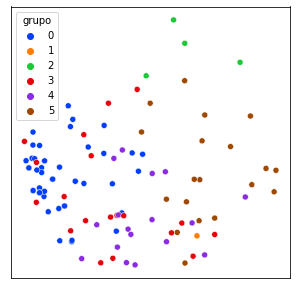

Cluster 1
A1 P1 BPI 2017
A1 P5 BPI 2020
A1 P6 BPI 2020
A10 P1 BPI 2017
A10 P2 BPI 2019
A10 P4 BPI 2020
A10 P5 BPI 2020
A12 P4 BPI 2020
A12 P6 BPI 2020
A13 P4 BPI 2020
A13 P5 BPI 2020
A13 P6 BPI 2020
A14 P1 BPI 2017
A15 P1 BPI 2017
A16 P1 BPI 2017
A16 P5 BPI 2020
A16 P6 BPI 2020
A17 P1 BPI 2017
A18 P1 BPI 2017
A18 P4 BPI 2020
A18 P5 BPI 2020
A19 P1 BPI 2017
A2 P4 BPI 2020
A2 P5 BPI 2015
A2 P5 BPI 2020
A2 P6 BPI 2020
A21 P1 BPI 2017
A23 P1 BPI 2017
A24 P4 BPI 2020
A25 P4 BPI 2020
A25 P5 BPI 2020
A25 P6 BPI 2020
A26 P5 BPI 2020
A26 P6 BPI 2020
A27 P5 BPI 2020
A28 P4 BPI 2020
A28 P5 BPI 2020
A3 P2 BPI 2019
A3 P5 BPI 2015
A30 P6 BPI 2020
A35 P5 BPI 2020
A35 P6 BPI 2020
A37 P4 BPI 2020
A4 P5 BPI 2015
A5 P1 BPI 2017
A6 P5 BPI 2015
A7 P5 BPI 2015
A7 P5 BPI 2020
A7 P6 BPI 2020

Cluster 2
A19 P4 BPI 2020
A19 P5 BPI 2020

Cluster 3
A11 P1 BPI 2017
A12 P1 BPI 2017
A2 P2 BPI 2019
A6 P1 BPI 2017

Cluster 4
A11 P4 BPI 2020
A12 P1-P2 BPI 2020
A12 P5 BPI 2020
A13 P1 BPI 2017
A19 P1-P2 BPI 2020
A2 P1 BP

In [18]:
muestra_agrupacion(matriz, kmeans6.labels_)

columns=['Cluster','P1-P2 BPI 2020','P4 BPI 2020','P5 BPI 2020','P6 BPI 2020', 'P5 BPI 2015', 'P1 BPI 2017']
#columna es el case_ID
df_clusters= pd.DataFrame(columns=columns)
df_clusters2= pd.DataFrame(columns=columns)
for n in range(kmeans6.n_clusters):
    print('Cluster' ,  n+1) 
    a=0
#     b=0
    c=0
    d=0
    e=0
    f=0
    g=0
    for s in range(len(matriz)):
        if (kmeans6.labels_[s] == n):
            print(matriz.index[s])
            if(matriz.index[s].find("P1-P2 BPI 2020") != -1):
                a = a + 1
#             elif(matriz.index[s].find("P2 BPI 2020") != -1):
#                 b = b + 1
            elif(matriz.index[s].find("P4 BPI 2020") != -1):
                c = c + 1
            elif(matriz.index[s].find("P5 BPI 2020") != -1):
                d = d + 1
            elif(matriz.index[s].find("P6 BPI 2020") != -1):
                e = e + 1
            elif(matriz.index[s].find("P5 BPI 2015") != -1):
                f = f + 1
            elif(matriz.index[s].find("P1 BPI 2017") != -1):
                g = g + 1
    df_clusters.loc[n] = (n+1, a*100/9, c*100/8, d*100/9, e*100/9, f*100/6, g*100/17)
    df_clusters2.loc[n] = (n+1, a, c, d, e, f, g)
    print("")

In [19]:
cluster1 = pd.DataFrame()
cluster2 = pd.DataFrame()
cluster3 = pd.DataFrame()
cluster4 = pd.DataFrame()
cluster5 = pd.DataFrame()
cluster6 = pd.DataFrame()
row=0

for n in range(kmeans6.n_clusters):
    for s in range(len(matriz)):
        if (kmeans6.labels_[s] == n):
            for row in range(len(df_prueba)):
                if (df_prueba['case:concept:name'][row] == matriz.index[s]):
                    new_row=df_prueba.iloc[row]
                    if(n==0):
                        cluster1 = cluster1.append(new_row, ignore_index=True)
                    elif(n==1):
                        cluster2 = cluster2.append(new_row, ignore_index=True)
                    elif(n==2):
                        cluster3 = cluster3.append(new_row, ignore_index=True)
                    elif(n==3):
                        cluster4 = cluster4.append(new_row, ignore_index=True)
                    elif(n==4):
                        cluster5 = cluster5.append(new_row, ignore_index=True)
                    elif(n==5):
                        cluster6 = cluster6.append(new_row, ignore_index=True)

In [73]:
df_clusters.to_csv('info-clusters.csv')
df_clusters2.to_csv('info-clusters2.csv')
cluster1.to_csv('cluster1.csv')
cluster2.to_csv('cluster2.csv')
cluster3.to_csv('cluster3.csv')
cluster4.to_csv('cluster4.csv')
cluster5.to_csv('cluster5.csv')
cluster6.to_csv('cluster6.csv')

In [30]:
log2 = log_converter.apply(cluster2)
xes_exporter.apply(log2, './Cluster 2 kmeans.xes')

log1 = log_converter.apply(cluster1)
xes_exporter.apply(log1, './Cluster 1 kmeans.xes')

log3 = log_converter.apply(cluster3)
xes_exporter.apply(log3, './Cluster 3 kmeans.xes')

log4 = log_converter.apply(cluster4)
xes_exporter.apply(log4, './Cluster 4 kmeans.xes')

log5 = log_converter.apply(cluster5)
xes_exporter.apply(log5, './Cluster 5 kmeans.xes')

log6 = log_converter.apply(cluster6)
xes_exporter.apply(log6, './Cluster 6 kmeans.xes')

### AgglomerativeClustering

Linkage:
- 'ward' minimiza la variación de los grupos que se fusionan. --> por defecto

- "average" utiliza el promedio de las distancias de cada observación de los dos conjuntos.

- "complete" utiliza las distancias máximas entre todas las observaciones de los dos conjuntos.

In [27]:
METRICAS2 = pd.DataFrame(columns=['SILHOUETTE', 'CALINSKI'])

agc = AgglomerativeClustering(n_clusters=2).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-2'] = (silhouette_score(matriz, agc.labels_), calinski_harabasz_score(matriz, agc.labels_))

agc3 = AgglomerativeClustering(n_clusters=3).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-3'] = (silhouette_score(matriz, agc3.labels_), calinski_harabasz_score(matriz, agc3.labels_))

agc4 = AgglomerativeClustering(n_clusters=4).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-4'] = (silhouette_score(matriz, agc4.labels_), calinski_harabasz_score(matriz, agc4.labels_))

agc5 = AgglomerativeClustering(n_clusters=5).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-5'] = (silhouette_score(matriz, agc5.labels_) , calinski_harabasz_score(matriz, agc5.labels_))

agc6 = AgglomerativeClustering(n_clusters=6).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-6'] = (silhouette_score(matriz, agc6.labels_), calinski_harabasz_score(matriz, agc6.labels_))

agc7 = AgglomerativeClustering(n_clusters=7).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-7'] = (silhouette_score(matriz, agc7.labels_), calinski_harabasz_score(matriz, agc7.labels_))

agc8 = AgglomerativeClustering(n_clusters=8).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-8'] = (silhouette_score(matriz, agc8.labels_) , calinski_harabasz_score(matriz, agc8.labels_))

agc9 = AgglomerativeClustering(n_clusters=9).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-9'] = (silhouette_score(matriz, agc9.labels_) , calinski_harabasz_score(matriz, agc9.labels_))

agc10 = AgglomerativeClustering(n_clusters=10).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-10'] = (silhouette_score(matriz, agc10.labels_), calinski_harabasz_score(matriz, agc10.labels_))


METRICAS2

,SILHOUETTE,CALINSKI
AGGLOMERATIVE-2,0.087396,12.061502
AGGLOMERATIVE-3,0.083896,9.640603
AGGLOMERATIVE-4,0.087083,8.753997
AGGLOMERATIVE-5,0.097004,8.060383
AGGLOMERATIVE-6,0.089900,7.509383
AGGLOMERATIVE-7,0.100116,7.142561
AGGLOMERATIVE-8,0.107909,6.863979
AGGLOMERATIVE-9,0.113773,6.677171
AGGLOMERATIVE-10,0.120338,6.521793


In [28]:
METRICAS3 = pd.DataFrame(columns=['SILHOUETTE', 'CALINSKI'])
a= AgglomerativeClustering(n_clusters=2, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='ward', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-2-defecto'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))
a= AgglomerativeClustering(n_clusters=6, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='ward', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-6-defecto'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))
a= AgglomerativeClustering(n_clusters=2, affinity='manhattan', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='average', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-2-manh-av'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))
a= AgglomerativeClustering(n_clusters=6, affinity='manhattan', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='average', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-6-manh-av'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))
a= AgglomerativeClustering(n_clusters=2, affinity='manhattan', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='complete', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-2-manh-comp'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))
a= AgglomerativeClustering(n_clusters=6, affinity='manhattan', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='complete', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-6-manh-comp'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))
a= AgglomerativeClustering(n_clusters=2, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='single', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-2-cos-sing'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))
a= AgglomerativeClustering(n_clusters=6, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='single', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-6-cos-sing'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))

METRICAS3

,SILHOUETTE,CALINSKI
Agglomerative-2-defecto,0.087396,12.061502
Agglomerative-6-defecto,0.089900,7.509383
Agglomerative-2-manh-av,0.272395,2.657365
Agglomerative-6-manh-av,0.140084,2.526331
Agglomerative-2-manh-comp,0.118736,12.346825
Agglomerative-6-manh-comp,0.060631,6.483740
Agglomerative-2-cos-sing,0.257243,2.475251
Agglomerative-6-cos-sing,0.144453,2.394098


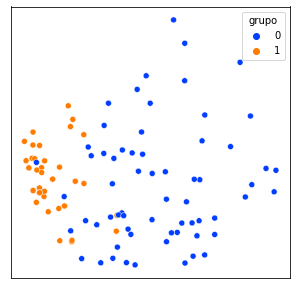

Cluster 1
A1 P1-P2 BPI 2020
A1 P2 BPI 2019
A1 P5 BPI 2015
A10 P1-P2 BPI 2020
A10 P2 BPI 2019
A10 P6 BPI 2020
A11 P1 BPI 2017
A11 P1-P2 BPI 2020
A11 P2 BPI 2019
A11 P4 BPI 2020
A11 P5 BPI 2020
A12 P1 BPI 2017
A12 P2 BPI 2019
A13 P1 BPI 2017
A13 P1-P2 BPI 2020
A13 P2 BPI 2019
A14 P1 BPI 2017
A14 P2 BPI 2019
A15 P2 BPI 2019
A16 P1 BPI 2017
A16 P1-P2 BPI 2020
A16 P4 BPI 2020
A16 P5 BPI 2020
A18 P1-P2 BPI 2020
A19 P1-P2 BPI 2020
A19 P4 BPI 2020
A19 P5 BPI 2020
A2 P1 BPI 2017
A2 P1-P2 BPI 2020
A2 P2 BPI 2019
A22 P1 BPI 2017
A24 P1-P2 BPI 2020
A24 P4 BPI 2020
A25 P1-P2 BPI 2020
A26 P1-P2 BPI 2020
A26 P4 BPI 2020
A27 P1-P2 BPI 2020
A27 P4 BPI 2020
A28 P1-P2 BPI 2020
A3 P1 BPI 2017
A3 P2 BPI 2019
A30 P1-P2 BPI 2020
A30 P5 BPI 2020
A31 P1-P2 BPI 2020
A31 P4 BPI 2020
A34 P1-P2 BPI 2020
A34 P5 BPI 2020
A35 P1-P2 BPI 2020
A35 P4 BPI 2020
A37 P1-P2 BPI 2020
A37 P5 BPI 2020
A37 P6 BPI 2020
A4 P2 BPI 2019
A5 P2 BPI 2019
A5 P5 BPI 2015
A6 P1 BPI 2017
A6 P5 BPI 2015
A7 P1 BPI 2017
A7 P1-P2 BPI 2020
A7 P

In [29]:
muestra_agrupacion(matriz, agc.labels_)

columns=['Cluster','P1-P2 BPI 2020','P4 BPI 2020','P5 BPI 2020','P6 BPI 2020', 'P5 BPI 2015', 'P1 BPI 2017']
#columna es el case_ID
df_clusters3= pd.DataFrame(columns=columns)
for n in range(agc.n_clusters):
    print('Cluster' ,  n+1) 
    a=0
    b=0
    c=0
    d=0
    e=0
    f=0
    g=0
    for s in range(len(matriz)):
        if (agc.labels_[s] == n):
            print(matriz.index[s])
            if(matriz.index[s].find("P1-P2 BPI 2020") != -1):
                a = a + 1
#             elif(matriz.index[s].find("P2 BPI 2020") != -1):
#                 b = b + 1
            elif(matriz.index[s].find("P4 BPI 2020") != -1):
                c = c + 1
            elif(matriz.index[s].find("P5 BPI 2020") != -1):
                d = d + 1
            elif(matriz.index[s].find("P6 BPI 2020") != -1):
                e = e + 1
            elif(matriz.index[s].find("P5 BPI 2015") != -1):
                f = f + 1
            elif(matriz.index[s].find("P1 BPI 2017") != -1):
                g = g + 1
    #df_clusters.loc[n] = (n+1, a*100/9, b*100/9, c*100/8, d*100/9, e*100/9, f*100/6, g*100/17)
    df_clusters3.loc[n] = (n+1, a, c, d, e, f, g)
    print("")

In [30]:
df_clusters3

,Cluster,P1-P2 BPI 2020,P4 BPI 2020,P5 BPI 2020,P6 BPI 2020,P5 BPI 2015,P1 BPI 2017
0,1,19,9,6,2,6,11
1,2,1,8,12,11,3,10


In [31]:
cluster1agc = pd.DataFrame()
cluster2agc = pd.DataFrame()
row=0

for n in range(agc.n_clusters):
    for s in range(len(matriz)):
        if (agc.labels_[s] == n):
            for row in range(len(df_prueba)):
                if (df_prueba['case:concept:name'][row] == matriz.index[s]):
                    new_row=df_prueba.iloc[row]
                    if(n==0):
                        cluster1agc = cluster1agc.append(new_row, ignore_index=True)
                    else:
                        cluster2agc = cluster2agc.append(new_row, ignore_index=True)

In [13]:
#log2agc = log_converter.apply(cluster2agc)
#xes_exporter.apply(log2agc, './Cluster 2 agc.xes')

#log1agc = log_converter.apply(cluster1agc)
#xes_exporter.apply(log1agc, './Cluster 1 agc.xes')

In [32]:
METRICAS2 = pd.DataFrame(columns=['SILHOUETTE', 'CALINSKI'])

agc2AV = AgglomerativeClustering(n_clusters=2, linkage='average').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-2-average'] = (silhouette_score(matriz, agc2AV.labels_), calinski_harabasz_score(matriz, agc2AV.labels_))

agc3AV = AgglomerativeClustering(n_clusters=3, linkage='average').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-3-average'] = (silhouette_score(matriz, agc3AV.labels_), calinski_harabasz_score(matriz, agc3AV.labels_))

agc4AV = AgglomerativeClustering(n_clusters=4, linkage='average').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-4-average'] = (silhouette_score(matriz, agc4AV.labels_), calinski_harabasz_score(matriz, agc4AV.labels_))

agc5AV = AgglomerativeClustering(n_clusters=5, linkage='average').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-5-average'] = (silhouette_score(matriz, agc5AV.labels_) , calinski_harabasz_score(matriz, agc5AV.labels_))

agc6AV = AgglomerativeClustering(n_clusters=6, linkage='average').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-6-average'] = (silhouette_score(matriz, agc6AV.labels_), calinski_harabasz_score(matriz, agc6AV.labels_))

agc2CMP = AgglomerativeClustering(n_clusters=2, linkage='complete').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-2-complete'] = (silhouette_score(matriz, agc2CMP.labels_), calinski_harabasz_score(matriz, agc2CMP.labels_))

agc3CMP = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-3-complete'] = (silhouette_score(matriz, agc3CMP.labels_), calinski_harabasz_score(matriz, agc3CMP.labels_))

agc4CMP = AgglomerativeClustering(n_clusters=4, linkage='complete').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-4-complete'] = (silhouette_score(matriz, agc4CMP.labels_), calinski_harabasz_score(matriz, agc4CMP.labels_))

agc5CMP = AgglomerativeClustering(n_clusters=5, linkage='complete').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-5-complete'] = (silhouette_score(matriz, agc5CMP.labels_) , calinski_harabasz_score(matriz, agc5CMP.labels_))

agc6CMP = AgglomerativeClustering(n_clusters=6, linkage='complete').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-6-complete'] = (silhouette_score(matriz, agc6CMP.labels_), calinski_harabasz_score(matriz, agc6CMP.labels_))

METRICAS2

,SILHOUETTE,CALINSKI
AGGLOMERATIVE-2-average,0.272395,2.657365
AGGLOMERATIVE-3-average,0.244565,2.610536
AGGLOMERATIVE-4-average,0.222569,2.593398
AGGLOMERATIVE-5-average,0.189950,2.511985
AGGLOMERATIVE-6-average,0.171274,3.444703
AGGLOMERATIVE-2-complete,0.118736,12.346825
AGGLOMERATIVE-3-complete,0.081797,9.148261
AGGLOMERATIVE-4-complete,0.093714,8.171806
AGGLOMERATIVE-5-complete,0.054089,6.858857
AGGLOMERATIVE-6-complete,0.060631,6.483740


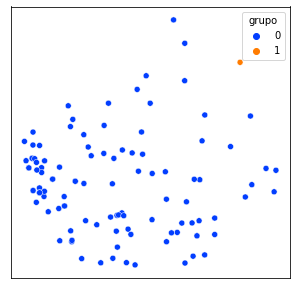

Cluster 0
A1 P1 BPI 2017
A1 P1-P2 BPI 2020
A1 P2 BPI 2019
A1 P5 BPI 2015
A1 P5 BPI 2020
A1 P6 BPI 2020
A10 P1 BPI 2017
A10 P1-P2 BPI 2020
A10 P2 BPI 2019
A10 P4 BPI 2020
A10 P5 BPI 2020
A10 P6 BPI 2020
A11 P1 BPI 2017
A11 P1-P2 BPI 2020
A11 P2 BPI 2019
A11 P4 BPI 2020
A11 P5 BPI 2020
A12 P1-P2 BPI 2020
A12 P2 BPI 2019
A12 P4 BPI 2020
A12 P5 BPI 2020
A12 P6 BPI 2020
A13 P1 BPI 2017
A13 P1-P2 BPI 2020
A13 P2 BPI 2019
A13 P4 BPI 2020
A13 P5 BPI 2020
A13 P6 BPI 2020
A14 P1 BPI 2017
A14 P2 BPI 2019
A15 P1 BPI 2017
A15 P2 BPI 2019
A16 P1 BPI 2017
A16 P1-P2 BPI 2020
A16 P4 BPI 2020
A16 P5 BPI 2020
A16 P6 BPI 2020
A17 P1 BPI 2017
A18 P1 BPI 2017
A18 P1-P2 BPI 2020
A18 P4 BPI 2020
A18 P5 BPI 2020
A19 P1 BPI 2017
A19 P1-P2 BPI 2020
A19 P4 BPI 2020
A19 P5 BPI 2020
A2 P1 BPI 2017
A2 P1-P2 BPI 2020
A2 P2 BPI 2019
A2 P4 BPI 2020
A2 P5 BPI 2015
A2 P5 BPI 2020
A2 P6 BPI 2020
A21 P1 BPI 2017
A22 P1 BPI 2017
A23 P1 BPI 2017
A24 P1-P2 BPI 2020
A24 P4 BPI 2020
A25 P1-P2 BPI 2020
A25 P4 BPI 2020
A25 P5 BPI

In [33]:
muestra_agrupacion(matriz, agc2AV.labels_)


for n in range(agc2AV.n_clusters):
    print('Cluster' ,  n) 
    for s in range(len(matriz)):
        if (agc2AV.labels_[s] == n):
            print(matriz.index[s])
            
                
    print("")

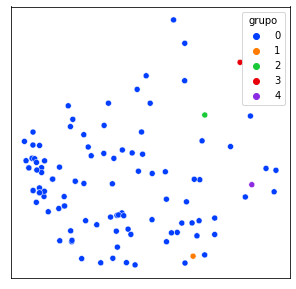

Cluster 0
A1 P1 BPI 2017
A1 P1-P2 BPI 2020
A1 P2 BPI 2019
A1 P5 BPI 2015
A1 P5 BPI 2020
A1 P6 BPI 2020
A10 P1 BPI 2017
A10 P1-P2 BPI 2020
A10 P2 BPI 2019
A10 P4 BPI 2020
A10 P5 BPI 2020
A10 P6 BPI 2020
A11 P1 BPI 2017
A11 P1-P2 BPI 2020
A11 P2 BPI 2019
A11 P4 BPI 2020
A12 P1-P2 BPI 2020
A12 P2 BPI 2019
A12 P4 BPI 2020
A12 P5 BPI 2020
A12 P6 BPI 2020
A13 P1 BPI 2017
A13 P1-P2 BPI 2020
A13 P2 BPI 2019
A13 P4 BPI 2020
A13 P5 BPI 2020
A13 P6 BPI 2020
A14 P1 BPI 2017
A15 P1 BPI 2017
A15 P2 BPI 2019
A16 P1 BPI 2017
A16 P1-P2 BPI 2020
A16 P4 BPI 2020
A16 P5 BPI 2020
A16 P6 BPI 2020
A17 P1 BPI 2017
A18 P1 BPI 2017
A18 P1-P2 BPI 2020
A18 P4 BPI 2020
A18 P5 BPI 2020
A19 P1 BPI 2017
A19 P4 BPI 2020
A19 P5 BPI 2020
A2 P1 BPI 2017
A2 P1-P2 BPI 2020
A2 P2 BPI 2019
A2 P4 BPI 2020
A2 P5 BPI 2015
A2 P5 BPI 2020
A2 P6 BPI 2020
A21 P1 BPI 2017
A22 P1 BPI 2017
A23 P1 BPI 2017
A24 P1-P2 BPI 2020
A24 P4 BPI 2020
A25 P1-P2 BPI 2020
A25 P4 BPI 2020
A25 P5 BPI 2020
A25 P6 BPI 2020
A26 P1-P2 BPI 2020
A26 P4 BPI

In [34]:
muestra_agrupacion(matriz, agc5AV.labels_)


for n in range(agc5AV.n_clusters):
    print('Cluster' ,  n) 
    for s in range(len(matriz)):
        if (agc5AV.labels_[s] == n):
            print(matriz.index[s])
            
    print("")

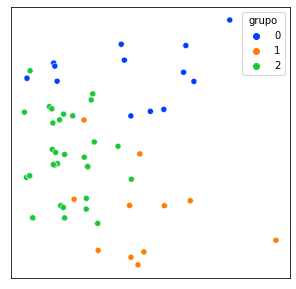

Cluster 1
A1 P2 BPI 2020
A13 P1 BPI 2020
A13 P2 BPI 2020
A2 P2 BPI 2020
A25 P1 BPI 2020
A25 P2 BPI 2020
A26 P2 BPI 2020
A28 P1 BPI 2020
A35 P1 BPI 2020
A35 P2 BPI 2020
A35 P4 BPI 2020
A37 P2 BPI 2020
A37 P6 BPI 2020
A7 P5 BPI 2015
A8 P5 BPI 2015
A9 P5 BPI 2015

Cluster 2
A1 P1 BPI 2017
A10 P1 BPI 2017
A11 P1 BPI 2017
A13 P1 BPI 2017
A17 P1 BPI 2017
A22 P1 BPI 2017
A37 P5 BPI 2020
A6 P1 BPI 2017
A7 P1 BPI 2017
A8 P1 BPI 2017
A9 P1 BPI 2017

Cluster 3
A1 P1 BPI 2020
A1 P5 BPI 2020
A1 P6 BPI 2020
A12 P1 BPI 2020
A12 P2 BPI 2020
A12 P4 BPI 2020
A12 P5 BPI 2020
A12 P6 BPI 2020
A13 P4 BPI 2020
A13 P5 BPI 2020
A13 P6 BPI 2020
A14 P1 BPI 2017
A15 P1 BPI 2017
A16 P1 BPI 2017
A2 P1 BPI 2017
A2 P1 BPI 2020
A2 P4 BPI 2020
A2 P5 BPI 2015
A2 P5 BPI 2020
A2 P6 BPI 2020
A21 P1 BPI 2017
A23 P1 BPI 2017
A25 P4 BPI 2020
A25 P5 BPI 2020
A25 P6 BPI 2020
A26 P1 BPI 2020
A26 P4 BPI 2020
A26 P5 BPI 2020
A26 P6 BPI 2020
A28 P2 BPI 2020
A28 P4 BPI 2020
A28 P5 BPI 2020
A28 P6 BPI 2020
A3 P5 BPI 2015
A35 P5 BPI 2

In [41]:
muestra_agrupacion(matriz, agc3CMP.labels_)
columns=['Cluster','P1 BPI 2020','P2 BPI 2020','P4 BPI 2020','P5 BPI 2020','P6 BPI 2020', 'P5 BPI 2015', 'P1 BPI 2017']
#columna es el case_ID
df_clusters_agg= pd.DataFrame(columns=columns)
for n in range(agc3CMP.n_clusters):
    print('Cluster' ,  n+1) 
    a=0
    b=0
    c=0
    d=0
    e=0
    f=0
    g=0
    for s in range(len(matriz)):
        if (agc3CMP.labels_[s] == n):
            print(matriz.index[s])
            if(matriz.index[s].find("P1 BPI 2020") != -1):
                a = a + 1
            elif(matriz.index[s].find("P2 BPI 2020") != -1):
                b = b + 1
            elif(matriz.index[s].find("P4 BPI 2020") != -1):
                c = c + 1
            elif(matriz.index[s].find("P5 BPI 2020") != -1):
                d = d + 1
            elif(matriz.index[s].find("P6 BPI 2020") != -1):
                e = e + 1
            elif(matriz.index[s].find("P5 BPI 2015") != -1):
                f = f + 1
            elif(matriz.index[s].find("P1 BPI 2017") != -1):
                g = g + 1
    df_clusters_agg.loc[n] = (n+1, a*100/9, b*100/9, c*100/8, d*100/9, e*100/9, f*100/6, g*100/17)
    print("")

In [42]:
df_clusters_agg

,Cluster,P1 BPI 2020,P2 BPI 2020,P4 BPI 2020,P5 BPI 2020,P6 BPI 2020,P5 BPI 2015,P1 BPI 2017
0,1.0,44.444444,77.777778,12.5,0.000000,11.111111,50.0,0.000000
1,2.0,0.000000,0.000000,0.0,11.111111,0.000000,0.0,58.823529
2,3.0,55.555556,22.222222,87.5,88.888889,88.888889,50.0,41.176471
